In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

In [79]:
df = pd.read_excel("premiums_young.xlsx")
print(f"Shape of Dataset {df.shape}")
df.head()

Shape of Dataset (20096, 13)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [80]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

##### As some of the columns have space between words and some have underscore, it would be better if all are in same format and here I wish this all column names to be in snake format(underscore) and turining it to lower letter. So

In [81]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

##### Check and handle NA values and Duplicate values

In [82]:
#Cheking for NA values
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [83]:
#As there are only few NA values comparitive to high volume of 50k record this is less. So dropping NA values
df.dropna(inplace=True)
print(f"Shape of Dataset after Dropping NA {df.shape}")
df.isna().sum()

Shape of Dataset after Dropping NA (20090, 13)


age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [84]:
#Checking for duplicated values
df.duplicated().sum
#Suppose if we have duplicates in future we can handle it by
df.drop_duplicates(inplace = True)
df.duplicated().sum()

0

In [85]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


##### From above describe() we are understand about some outliers in each field. It's needed to be handled

##### <span style="color:red">Handling Outliers in No_of_Dependants.</span>

In [86]:
print(f"Total records with age less than zero: {df[df.number_of_dependants<0].shape[0]}")
df[df.number_of_dependants<0]["number_of_dependants"].unique()

Total records with age less than zero: 22


array([-3, -1])

In [87]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
print(f"Total records with age less than zero: {df[df.number_of_dependants<0].shape[0]}")

Total records with age less than zero: 0


In [88]:
#Let's boxplot the numeric columns to find the outliers
numeric_cols = df.select_dtypes(["float64","int64"]).columns
numeric_cols

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

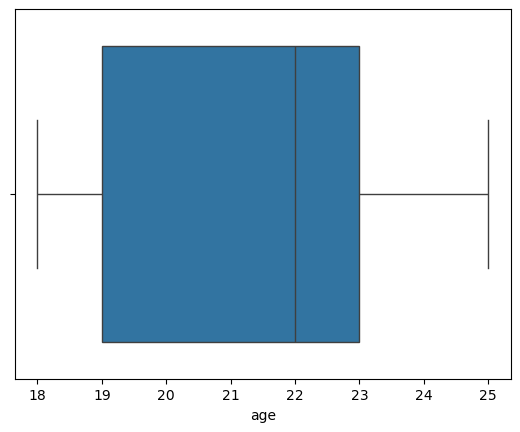

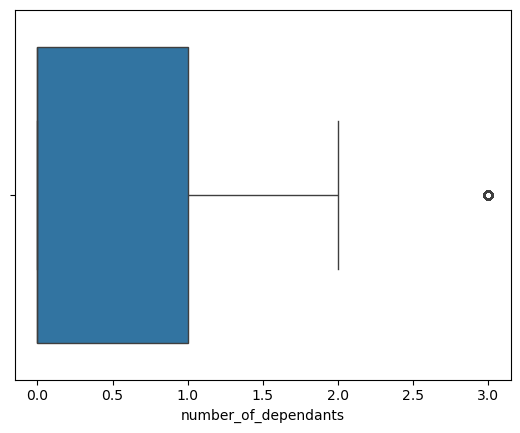

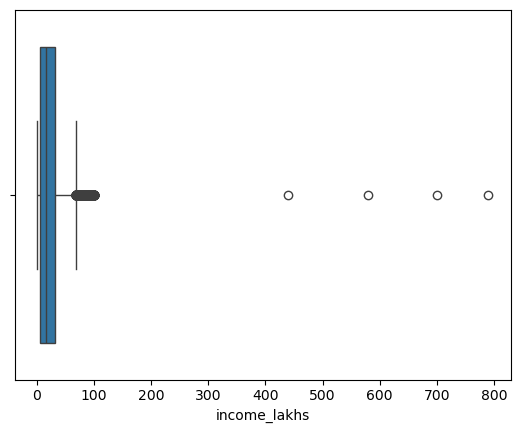

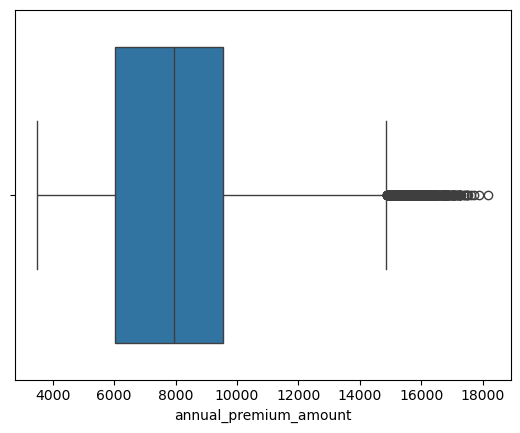

In [89]:
for col in numeric_cols:
    sns.boxplot(x =df[col])
    plt.show()

##### <span style="color:red">Handling Outliers in Age.</span>

In [90]:
#Let's keep the maximum value as hundred
df[df.age>100]["age"].unique()
#Only 5 values above 100. So Let's drop them
df1 = df[df.age<100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


##### <span style="color:red">Handling Outliers in Income.</span>

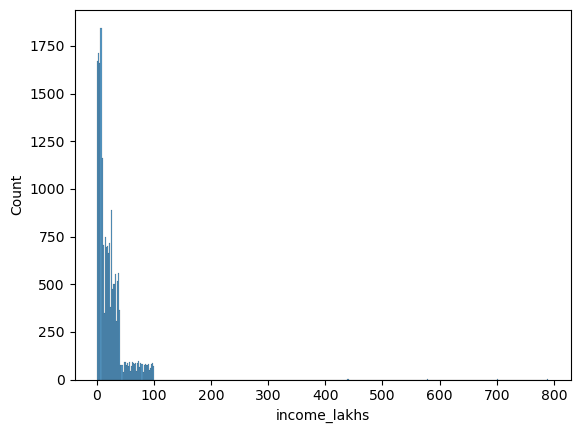

In [91]:
sns.histplot(df1.income_lakhs)
plt.show()

In [92]:
def get_iqr_bound(col):
    Q1, Q3 =col.quantile([.25,.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [93]:
get_iqr_bound(df1.income_lakhs)

(-31.5, 68.5)

In [94]:
# Though 67 lakh can be an income for a person, Let's keep upper_bound as 1 crore(100) for this! so
upper_bound = 100
df1[df1.income_lakhs>upper_bound].shape[0]

4

In [95]:
# We have just 10 records so it can be dropped for convenience
df2 =  df1[df1.income_lakhs<=upper_bound].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


##### That's all we have handled numeric columns. Annual_Premium_Amount column have no much outlier from boxplot. Let's plot Histogram for numeric columns to find how skewed the data in the column are.

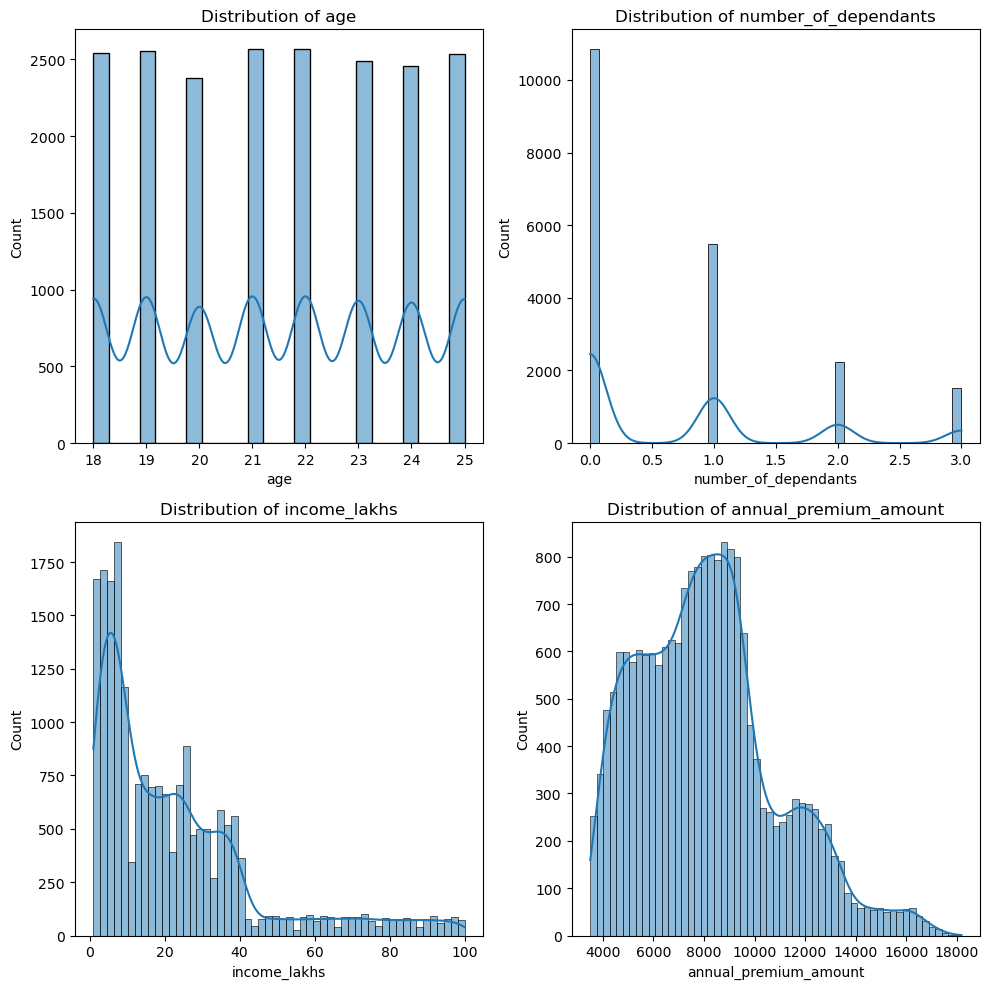

In [96]:
# Assuming df2 and numeric_cols are defined
n_cols = 2  # Number of columns per row
n_rows = -(-len(numeric_cols) // n_cols)  # Calculate number of rows (ceiling division)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))  # Adjust figsize for better visualization
axes = axes.flatten()  # Flatten axes to iterate easily

for i, col in enumerate(numeric_cols):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")  # Optional: Add a title for each plot

# Turn off unused axes if numeric_cols doesn't fill all subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Adjust spacing
plt.show()

##### From above we can find Age, income_lakhs and annual_premium_amount to be right skewed overall. Here above we have done univariate analysis. Let's try to do Bivariate analysis using scatter plot

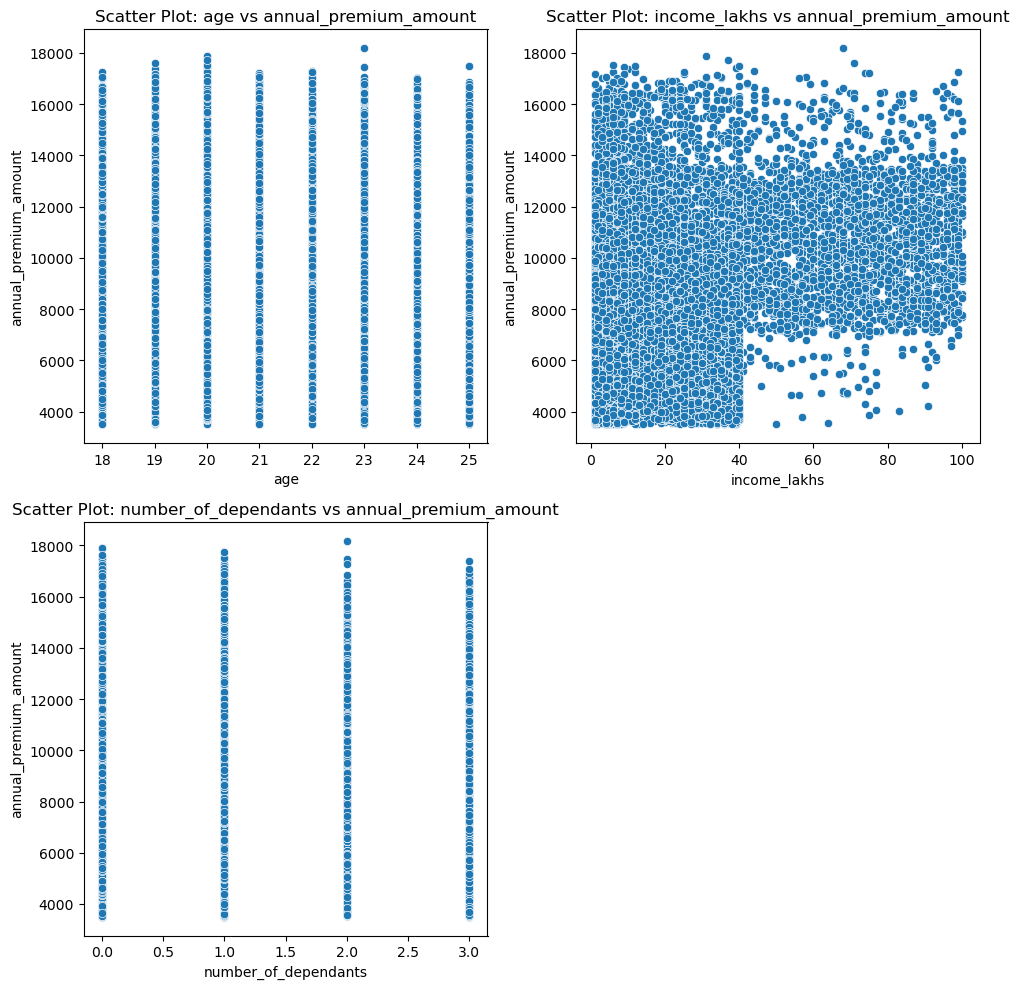

In [97]:
numeric_features = ["age", "income_lakhs", "number_of_dependants"]
y_col = "annual_premium_amount"  # Target column for y-axis
n_cols = 2  # Number of plots per row
n_rows = -(-len(numeric_features) // n_cols)  # Calculate number of rows (ceiling division)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))  # Adjust figure size
axes = axes.flatten()  # Flatten axes for easier iteration

for i, col in enumerate(numeric_features):
    sns.scatterplot(data=df2, x=col, y=y_col, ax=axes[i])
    axes[i].set_title(f"Scatter Plot: {col} vs {y_col}")  # Add title

# Turn off unused axes if there are any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

##### From above plot we can understand that Age and Annual premium amount have some pattern and others have no good pattern using scatter plot. Now let's analyse categorical columns.

In [98]:
categorical_cols = df2.select_dtypes(exclude=["float64", "int64"]).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [99]:
print("Unique values from Each columns....  \n")
for col in categorical_cols:
    print(col, ":" ,df2[col].unique())

Unique values from Each columns....  

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [100]:
#From above unqiue Categorical values we could find Smoking status values are not uniform. Let's uniform the values

df2["smoking_status"].replace({
    "Smoking=0" : "No Smoking",
     "Does Not Smoke" : "No Smoking",
     "Not Smoking" : "No Smoking"
},inplace=True)

df2["smoking_status"].unique()

/var/folders/md/3r5147mj0951vm3v86b8vymmjmg0m4/T/ipykernel_3205/3307579141.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["smoking_status"].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

##### Now Let's do Univariate Analysis on Categorical Columns.

In [101]:
#Percentage count for Gender Column
pct_count = df2["gender"].value_counts(normalize=True)*100
pct_count

gender
Male      55.038335
Female    44.961665
Name: proportion, dtype: float64

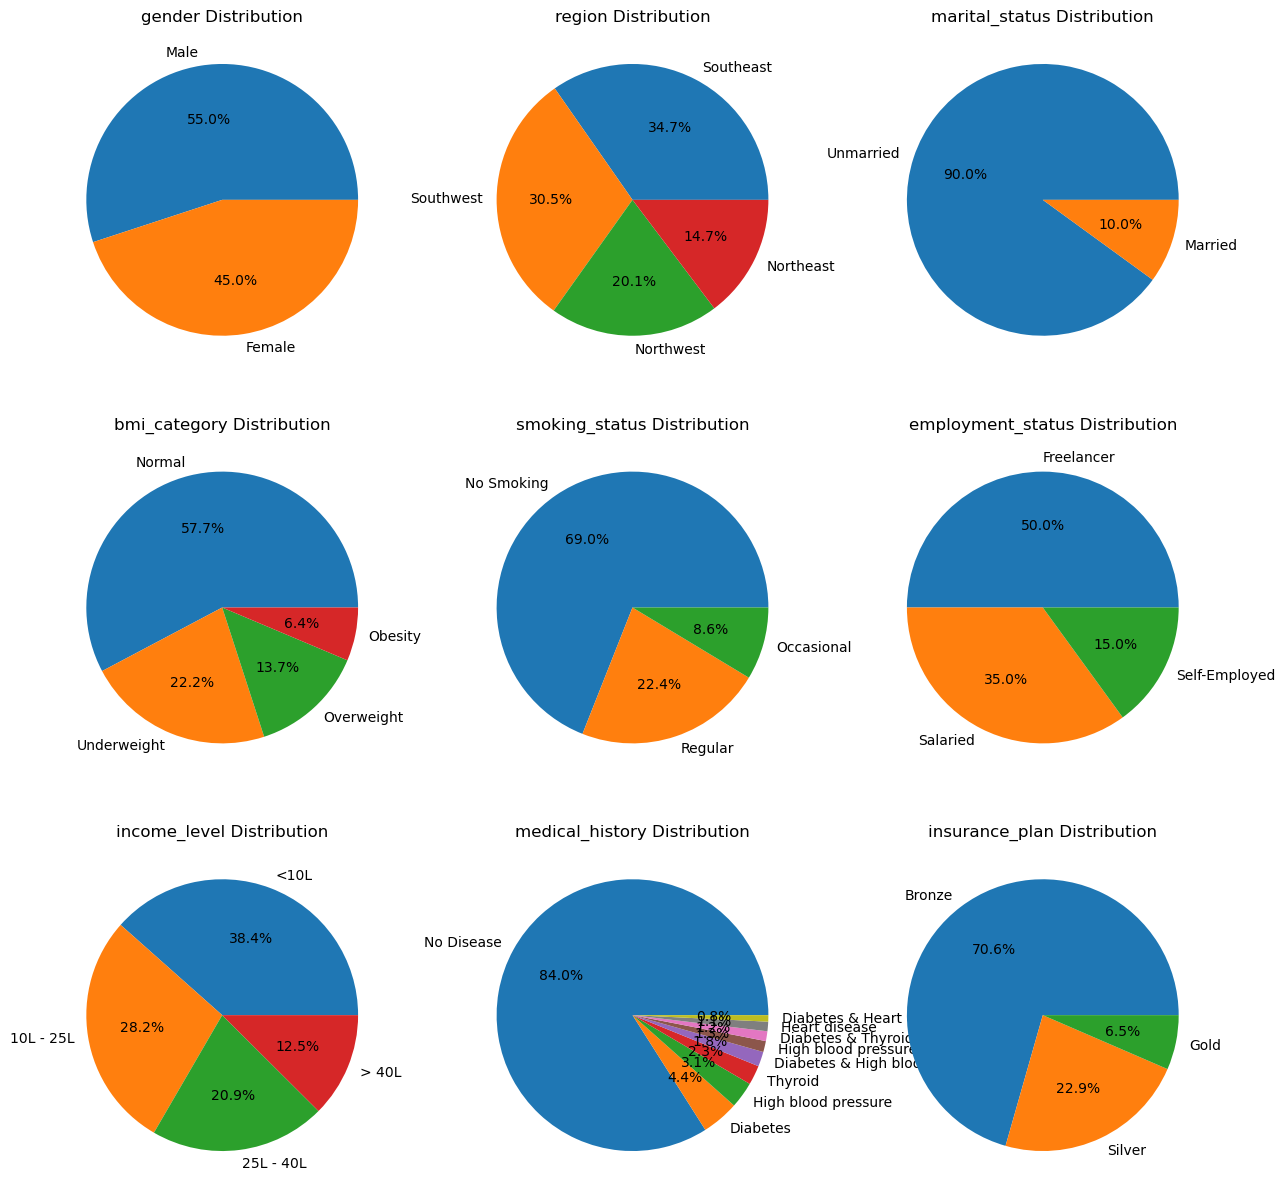

In [102]:
# Assuming df2 and categorical_cols are defined
n_cols = 3  # Number of charts per row
n_rows = -(-len(categorical_cols) // n_cols)  # Calculate number of rows (ceiling division)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust figure size
axes = axes.flatten()  # Flatten axes for easy iteration

for i, col in enumerate(categorical_cols):
    pct_count = df2[col].value_counts(normalize=True) * 100  # Calculate percentage
    axes[i].pie(pct_count, autopct='%1.1f%%', labels=pct_count.index)
    axes[i].set_title(f"{col} Distribution")
    
# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

In [103]:
#Using crosstab() let's do bivariate analysis on 2 columns
crosstab = pd.crosstab(df2["income_level"], df2["insurance_plan"])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,366,2023


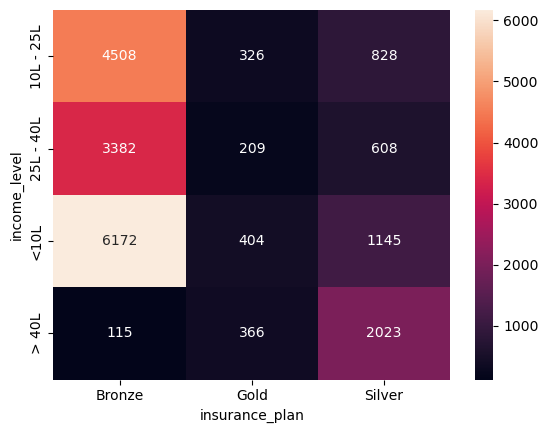

In [104]:
#Let's visualize it using heatmap
sns.heatmap(crosstab, annot=True, fmt='d')
plt.show()

### Feature Engineering

In [105]:
#Let's do feature engineering for medical_history
df2["medical_history"].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [106]:
#Risk scores are given by guide for each disease
risk_scores = {
    "diabetes" : 6,
    "heart disease" : 8,
    "high blood pressure" : 6,
    "thyroid" : 5,
    "no disease" : 0,
    "none" : 0
}

In [107]:
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
7290,25,Male,Southeast,Unmarried,1,Overweight,No Smoking,Salaried,10L - 25L,23,No Disease,Bronze,5440
6485,24,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,10L - 25L,24,Diabetes,Bronze,6882
16622,22,Male,Southeast,Married,3,Normal,Occasional,Self-Employed,> 40L,79,No Disease,Silver,12984
9065,22,Male,Northwest,Unmarried,0,Normal,Occasional,Salaried,10L - 25L,13,No Disease,Bronze,3907
3533,19,Female,Southeast,Married,3,Normal,Occasional,Freelancer,25L - 40L,36,Diabetes,Bronze,6212


In [108]:
#As some of rows have 2 disease concated using '&' first let's split them

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,None
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,None


In [109]:
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] =df2['disease2'].fillna('none')
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)
    

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
1186,20,Male,Northwest,Unmarried,0,Normal,No Smoking,Freelancer,25L - 40L,33,No Disease,Bronze,5188,no disease,none,0,0.000000
5283,19,Male,Southeast,Unmarried,1,Normal,Regular,Salaried,<10L,3,Heart disease,Silver,13422,heart disease,none,8,0.571429
19651,24,Male,Southeast,Unmarried,0,Normal,Regular,Freelancer,<10L,3,No Disease,Bronze,8132,no disease,none,0,0.000000
17333,18,Female,Southeast,Unmarried,2,Overweight,No Smoking,Salaried,<10L,1,No Disease,Bronze,9348,no disease,none,0,0.000000
6472,25,Female,Southeast,Unmarried,1,Obesity,No Smoking,Salaried,10L - 25L,11,No Disease,Silver,9727,no disease,none,0,0.000000


In [110]:
#Let's do feature engineering for insurance_plan

df2["insurance_plan"].unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [111]:
#As we find the values as ordinal values, we can just label encode using map()
df2["insurance_plan"] = df2["insurance_plan"].map({
    'Bronze' : 1,
    'Silver' : 2,
    'Gold' : 3
})
df2["insurance_plan"].unique()

array([2, 1, 3])

In [112]:
#Let's do feature engineering for income_level
df2["income_level"].unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [113]:
#As we find income_level values are also ordinal values, we can just label encode them using map()
df2["income_level"] = df2["income_level"].map({
    '<10L' : 1,
    '10L - 25L' : 2,
    '25L - 40L' : 3,
    '> 40L' : 4
})
df2["income_level"].unique()

array([4, 1, 2, 3])

In [114]:
#Other columns are nominal values and so will go with one hot encoding using get_dummies
nominal_cols =['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns = nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [115]:
#Let's drop not required columns
df4 = df3.drop(["medical_history", "disease1", "disease2", "total_risk_score"], axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


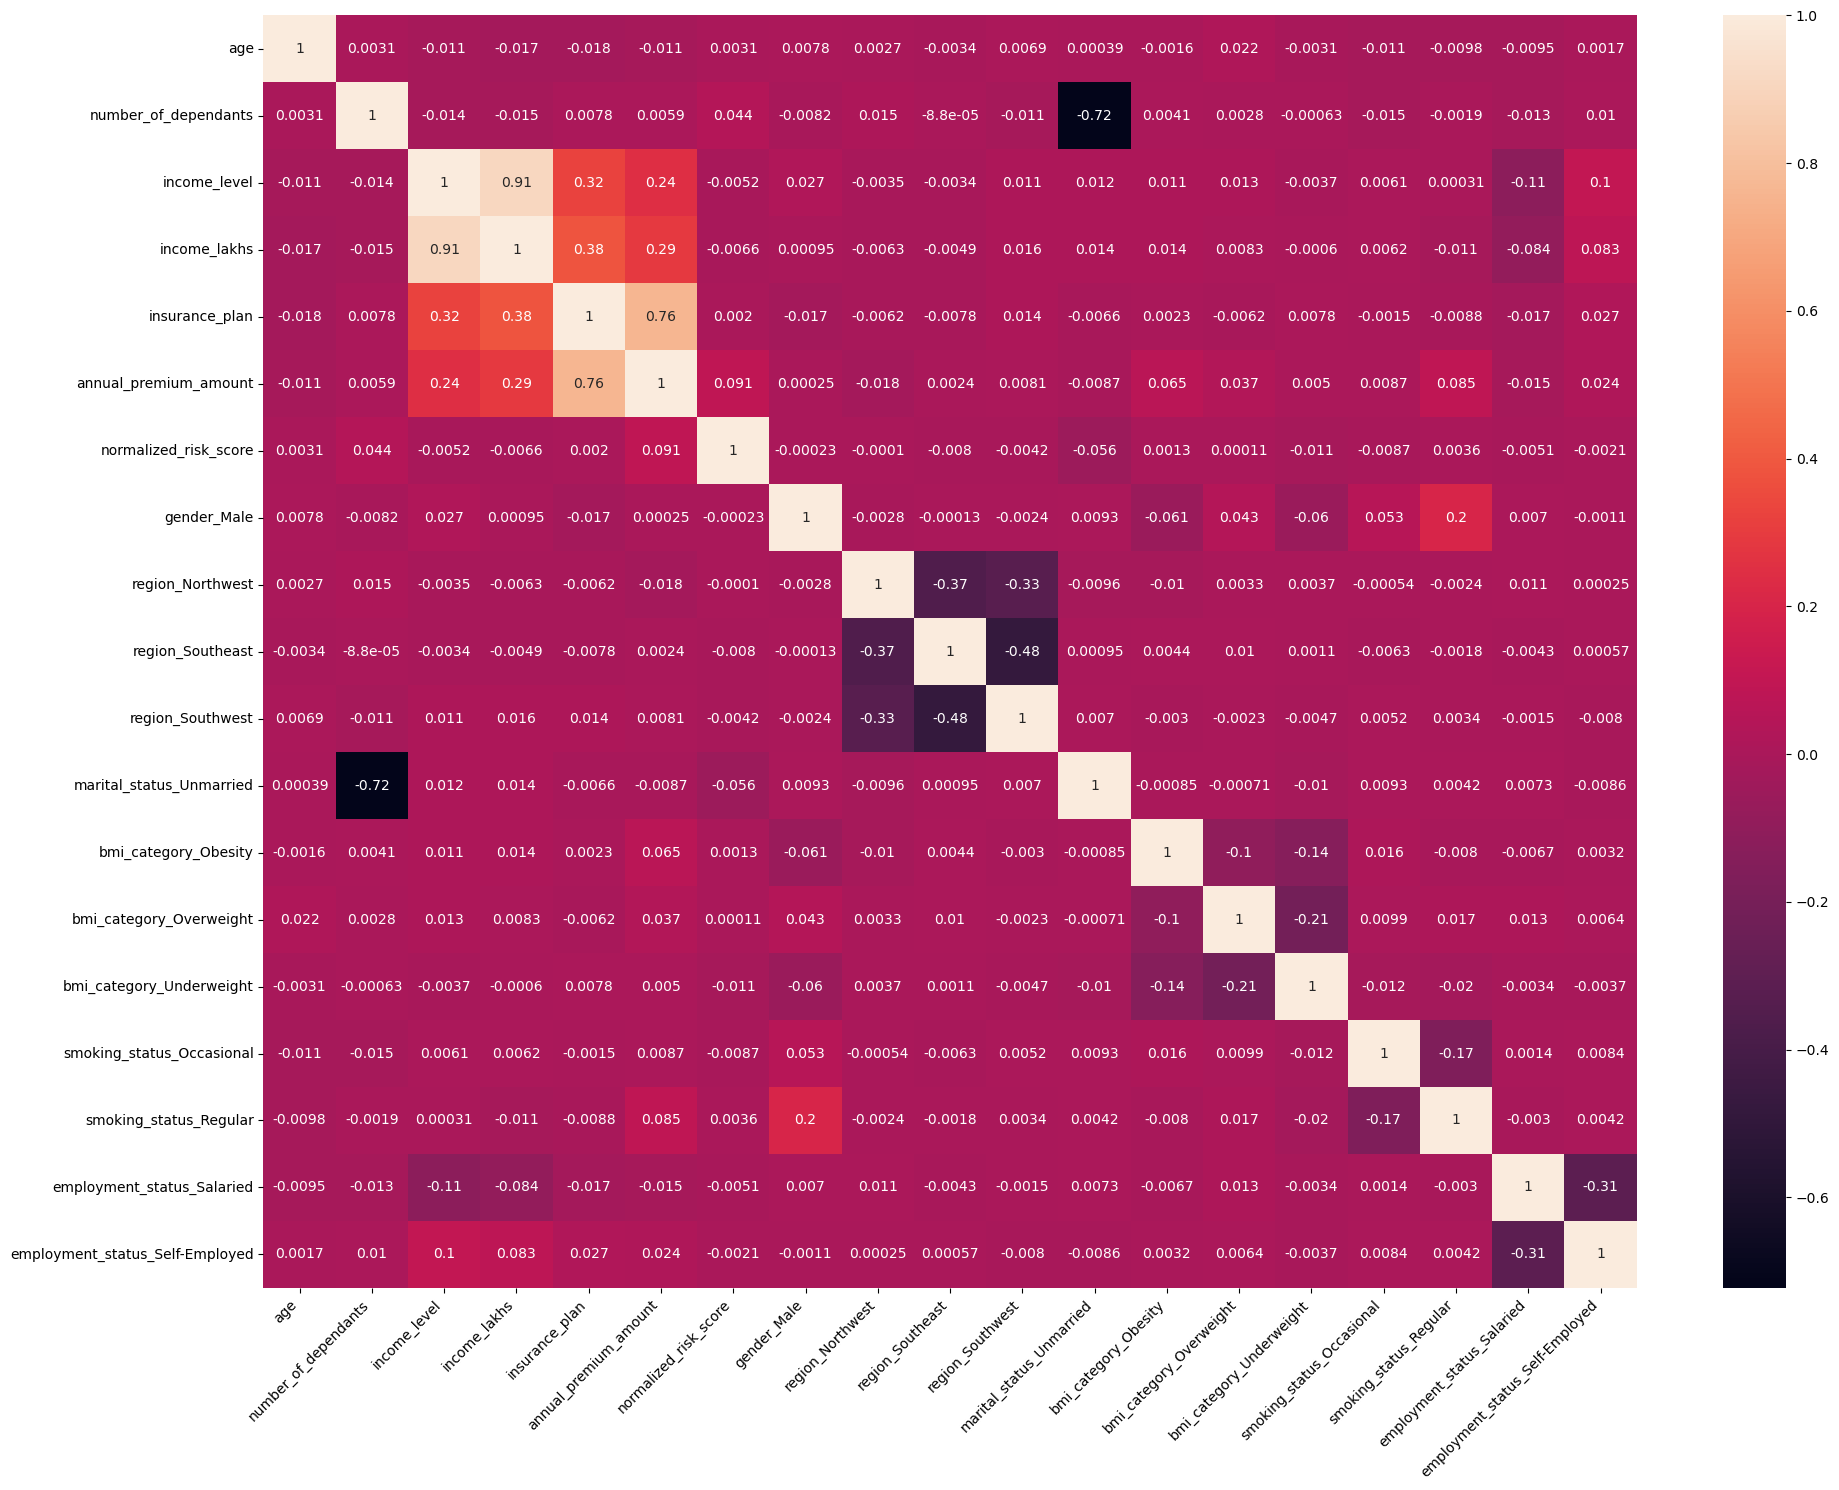

In [116]:
corr_mat = df4.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr_mat, annot=True)
plt.xticks(rotation= 45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [117]:
#To check columns to scel
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


In [118]:
#Let's do VIF(Variance Inflation Factor) to find relation of one feature with rest of features in aggregate way

X = df4.drop("annual_premium_amount", axis="columns") #Dropping target variable
y = df4["annual_premium_amount"] #Target Variable

#Doing scaling before VIF for getting good results
cols_to_scale = ["age", "number_of_dependants", "income_lakhs", "insurance_plan", "income_level"]
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [119]:
#Let's calculate VIF
def calculate_vif(data):
    data = data.dropna()
    data = data.fillna(data.mean())
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df
    

In [120]:
calculate_vif(X)

,Column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [121]:
#Any column having VIF greater than 10 can be dropped in descending order of VIF score
calculate_vif(X.drop("income_level", axis="columns")) #deopping high VIP column

,Column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [122]:
#For model training too let's drop the income_level column
X_reduced= X.drop("income_level", axis="columns")
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


#### MODEL TRAINING

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=.3, random_state=22)

print("X_train ... :", X_train.shape[0])
print("X_test ... :", X_test.shape[0])
print("y_train ... :", y_train.shape[0])
print("y_train ... :", y_test.shape[0])

X_train ... : 14060
X_test ... : 6026
y_train ... : 14060
y_train ... : 6026


In [124]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)

train_score, test_score

(0.6037907686532171, 0.601030997860446)

In [125]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print(f"Linear Regression ==> MSE: {mse_lr} .... RMSE: {rmse_lr}")

Linear Regression ==> MSE: 3009679.3259640527 .... RMSE: 1734.8427381074207


In [126]:
model_lr.intercept_

6612.7170984416025

In [127]:
feature_importance = model_lr.coef_ 
feature_importance

array([ 1.35425654e+01, -9.74806484e+01,  1.21321449e+01,  7.00097456e+03,
        1.00240509e+03,  5.81122460e-01, -1.12017634e+02, -2.14350143e+01,
       -4.13847418e+01, -6.41035968e+01,  8.08883647e+02,  4.41581914e+02,
        1.56472799e+02,  2.07658825e+02,  6.26995435e+02, -2.07675585e+01,
        1.44689339e+00])

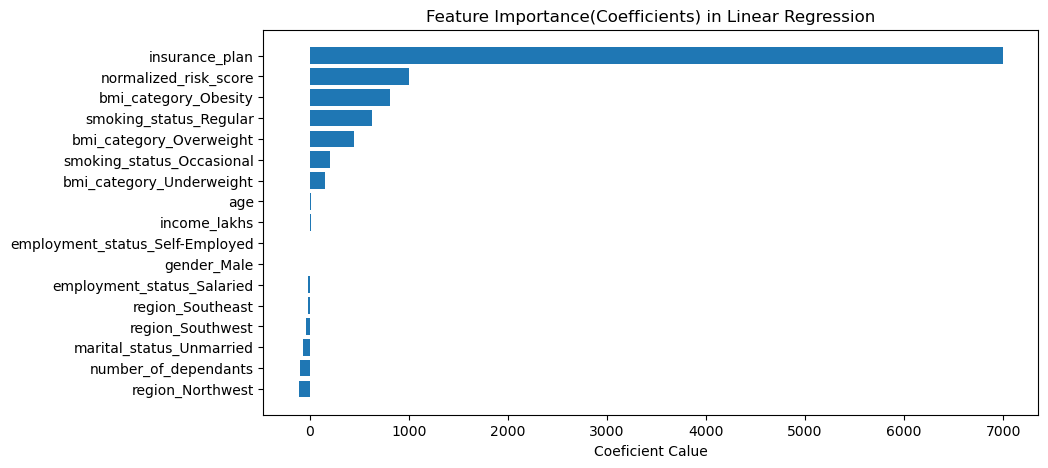

In [128]:
coef_df = pd.DataFrame(feature_importance, index=X_test.columns, columns=["Coeficients"])
coef_df = coef_df.sort_values(by="Coeficients", ascending=True)

plt.figure(figsize=(10,5))
plt.barh(coef_df.index, coef_df["Coeficients"])
plt.xlabel("Coeficient Calue")
plt.title("Feature Importance(Coefficients) in Linear Regression")
plt.show()

In [129]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)

train_score, test_score

(0.7290148735046387, 0.5596333146095276)

In [130]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print(f"XGBRegression ==> MSE: {mse_xgb} .... RMSE: {rmse_xgb}")

XGBRegression ==> MSE: 3321968.818626932 .... RMSE: 1822.6269005550564


In [131]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.6012228926022848

In [132]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [133]:
#Choosing best model as linear regression model as test and train have almost same efficiency score
best_model = model_lr 

#### ERROR ANALYSIS

In [134]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
3369,6325,7558.907235,1233.907235,19.508415
12397,5509,6453.844061,944.844061,17.150918
15372,8813,6426.078688,-2386.921312,-27.084095
11736,12363,14121.087473,1758.087473,14.220557
8685,7687,6515.702650,-1171.297350,-15.237379


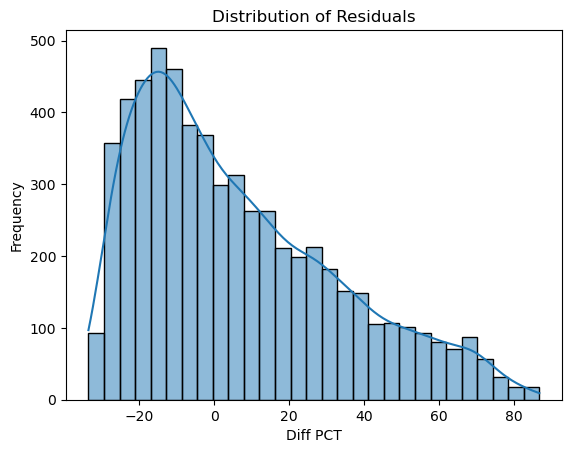

In [135]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [136]:
X_test.shape

(6026, 17)

In [137]:
extreme_error_threshold = 10  # You can adjust this threshold based on your domain knowledge or requirements
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
3369,6325,7558.907235,1233.907235,19.508415
12397,5509,6453.844061,944.844061,17.150918
15372,8813,6426.078688,-2386.921312,-27.084095
11736,12363,14121.087473,1758.087473,14.220557
8685,7687,6515.702650,-1171.297350,-15.237379


In [138]:
extreme_results_df.shape

(4393, 4)

In [139]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

72.90076335877863

In [140]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct
12058,3503,6540.037968,3037.037968,86.698201
7624,3502,6517.269662,3015.269662,86.101361
232,3505,6507.461034,3002.461034,85.662226
3652,3536,6545.377836,3009.377836,85.106839
15688,3603,6666.616587,3063.616587,85.029603
...,...,...,...,...
1873,4326,6495.878795,2169.878795,50.159011
1597,4653,6984.260633,2331.260633,50.102313
5090,4739,7112.540111,2373.540111,50.085252
19112,4361,6544.488395,2183.488395,50.068525


In [141]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
3369,0.857143,1.000000,0.353535,0.0,0.0,1,0,0,1,0,0,1,0,0,1,0,0
12397,0.714286,0.666667,0.111111,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0


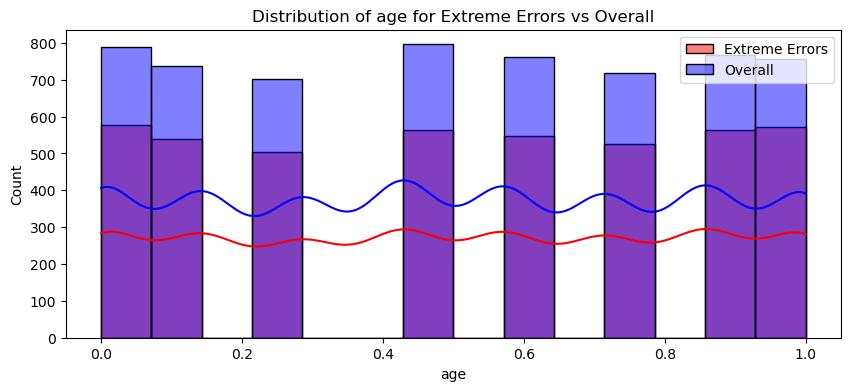

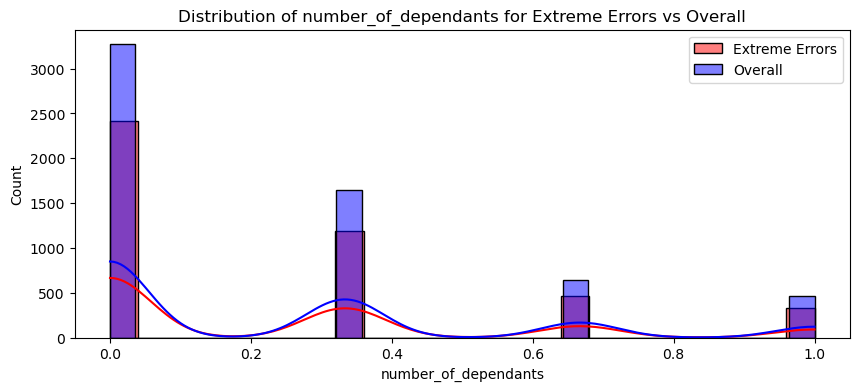

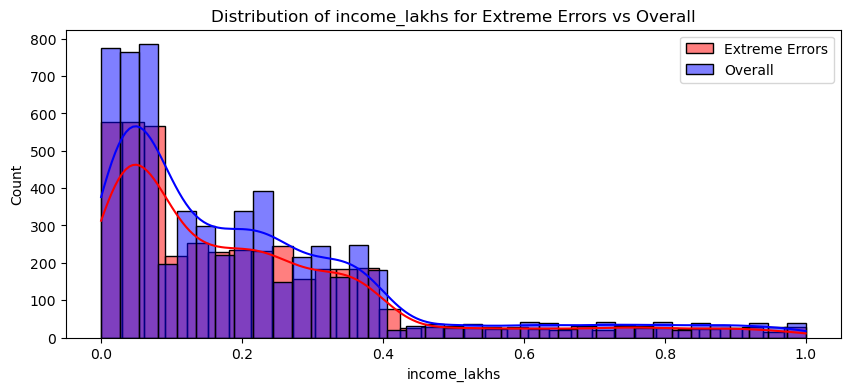

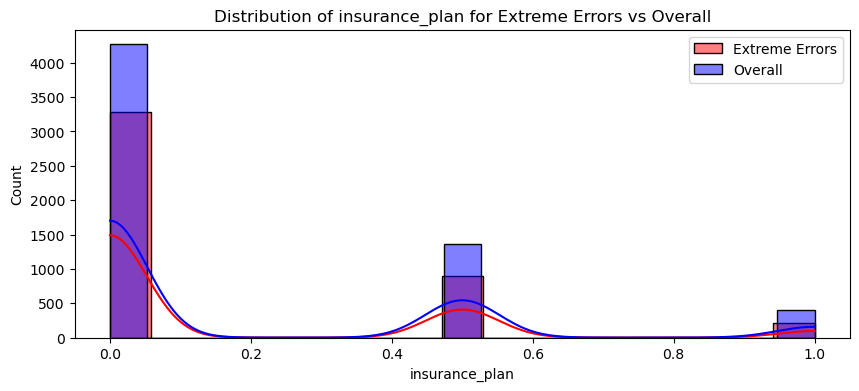

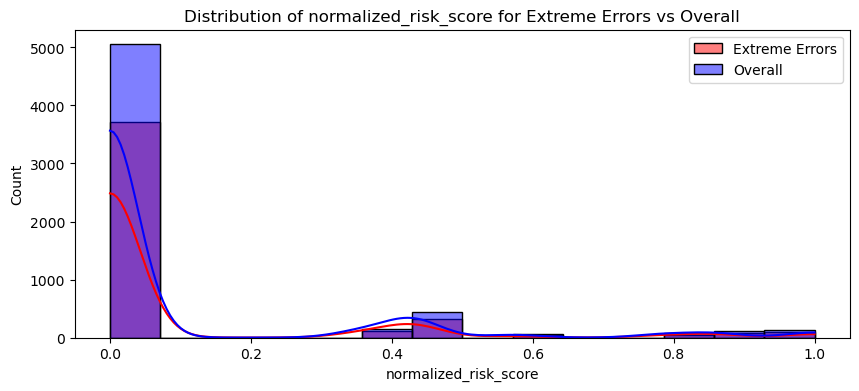

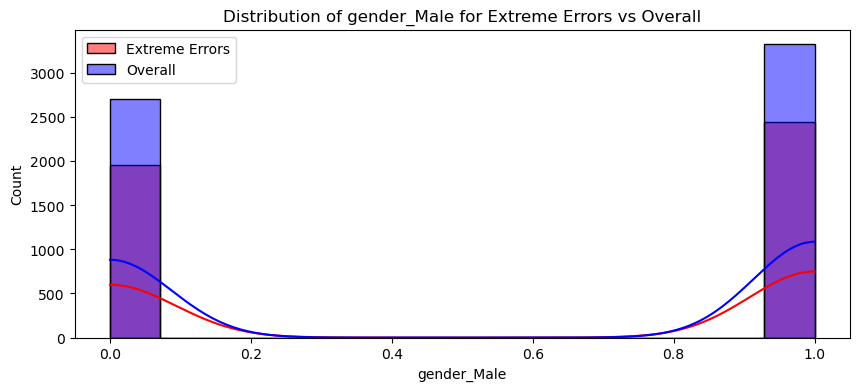

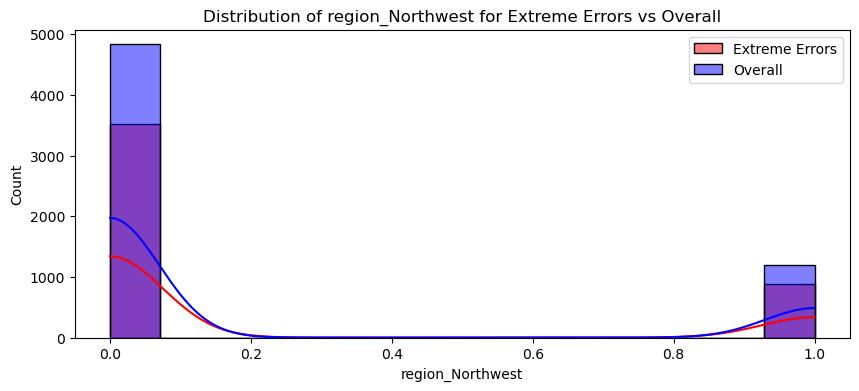

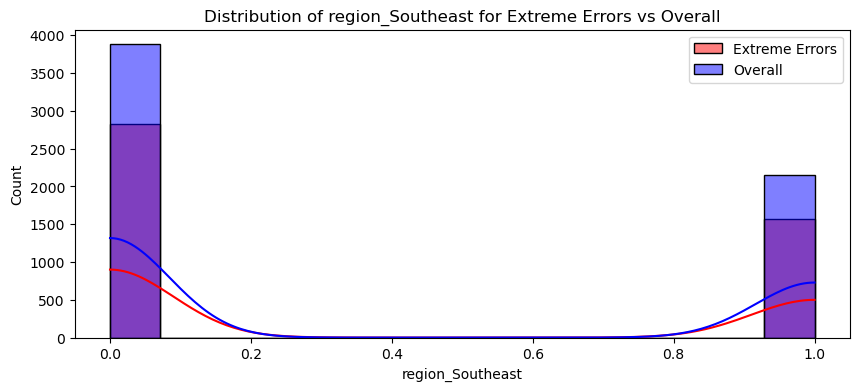

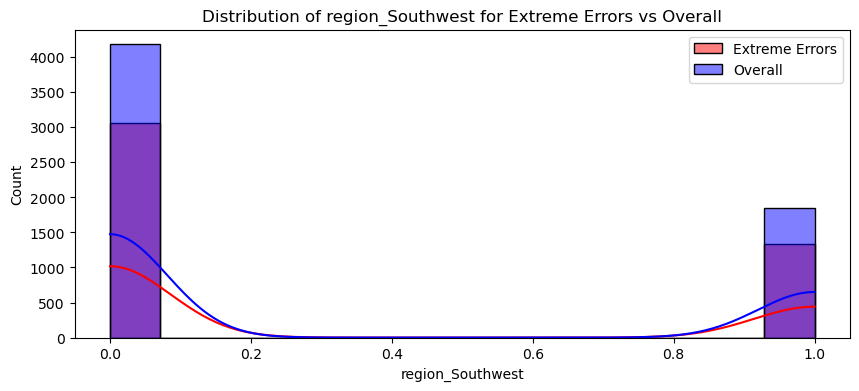

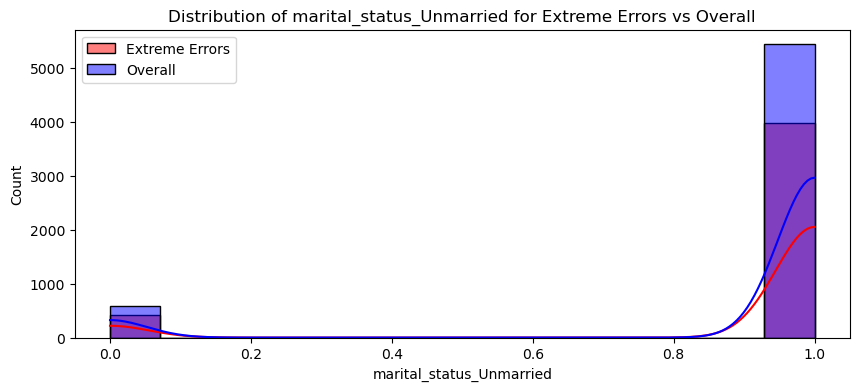

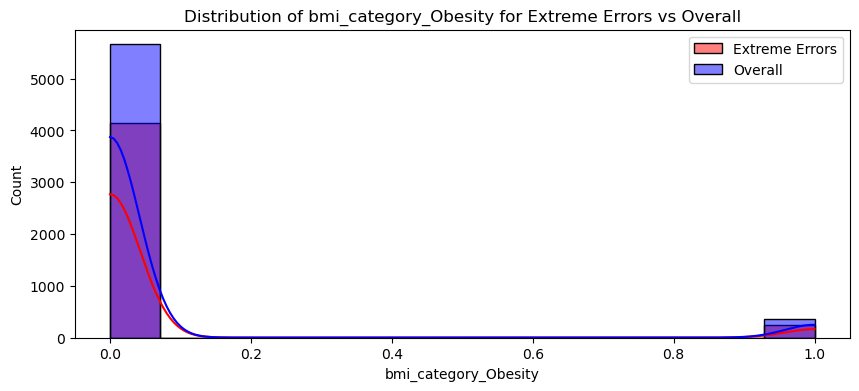

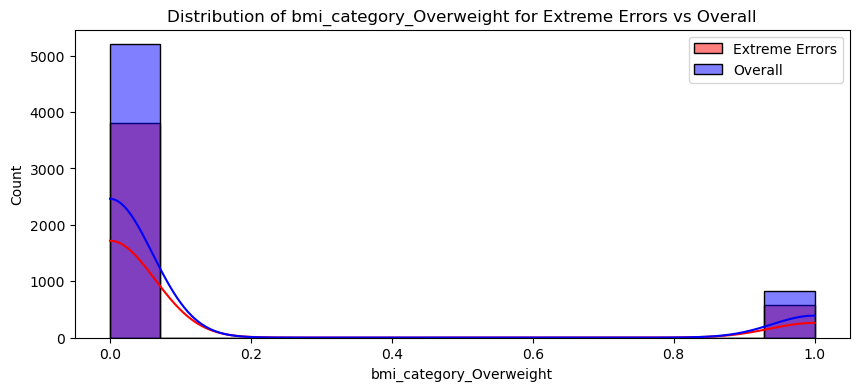

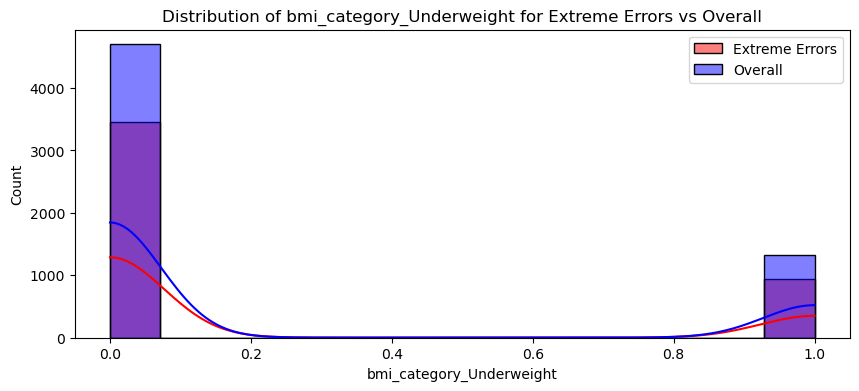

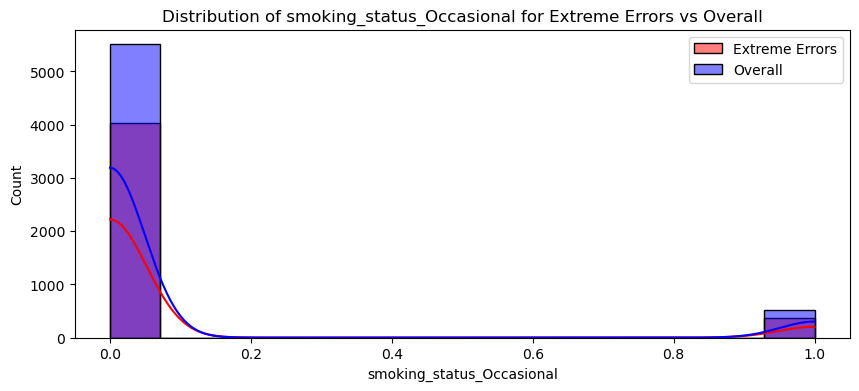

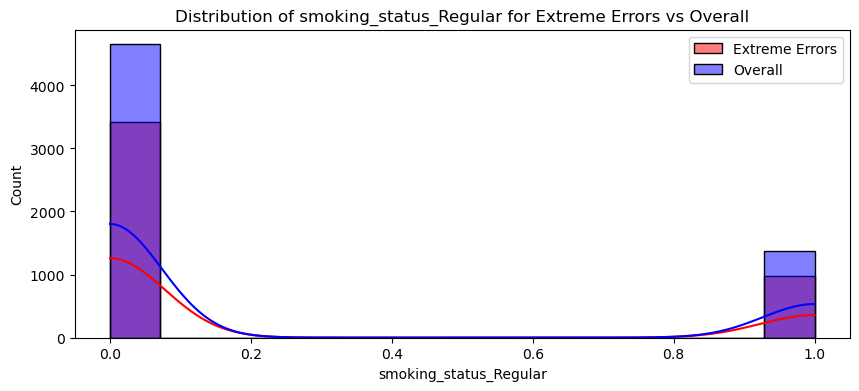

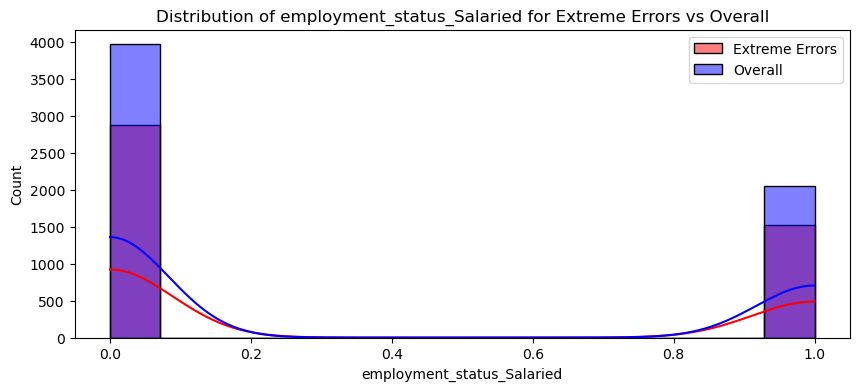

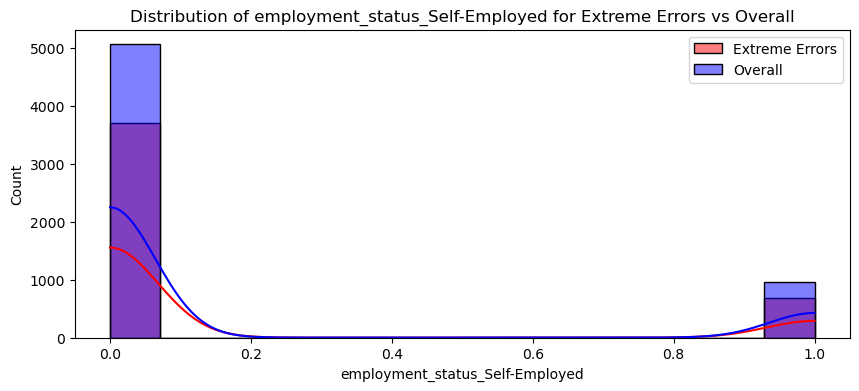

In [142]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()